In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge


## Carga de dataset

In [2]:
data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')


### Análisis Exploratorio de Datos (EDA)

i. Tipo de dato
Primero, verificamos los tipos de datos y su clasificación en el DataFrame:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                2311 non-null   int64  
 1   Trimester           2311 non-null   int64  
 2   District            2311 non-null   object 
 3   Neighbourhood       2311 non-null   object 
 4   Price (euro/month)  2311 non-null   float64
 5   Price (euro/m2)     2311 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 108.5+ KB


ii. Estadística descriptiva
Calculamos las estadísticas descriptivas para resumir la tendencia central, dispersión y forma de la distribución de los datos:

In [4]:
data.describe()

,Year,Trimester,Price (euro/month),Price (euro/m2)
count,2311.000000,2311.000000,2311.000000,2311.000000
mean,2017.745565,2.440502,820.780658,12.134531
std,2.463095,1.116498,255.450568,2.419414
min,2014.000000,1.000000,142.340000,3.180000
25%,2016.000000,1.000000,653.860000,10.500000
50%,2018.000000,2.000000,777.210000,12.100000
75%,2020.000000,3.000000,926.500000,13.750000
max,2022.000000,4.000000,2034.000000,21.300000


iii. Función de distribución
Visualizamos la distribución de la variable objetivo "Price (euro/m2)" utilizando un histograma:

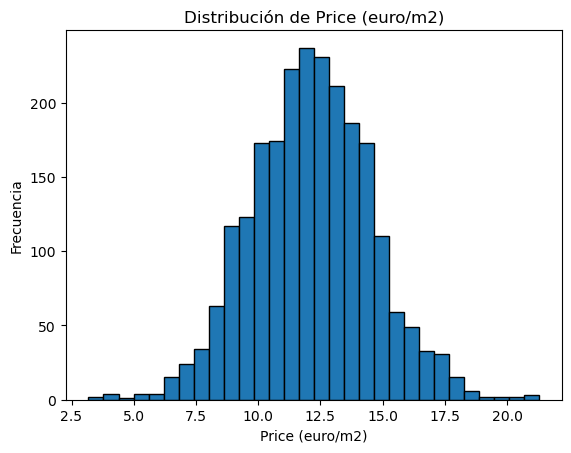

In [5]:
plt.hist(data['Price (euro/m2)'], bins=30, edgecolor='k')
plt.title('Distribución de Price (euro/m2)')
plt.xlabel('Price (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

In [6]:


# Prueba de Kolmogorov-Smirnov para 'Price (euro/m2)'
d, p_value = stats.kstest(data['Price (euro/m2)'], 'norm', args=(data['Price (euro/m2)'].mean(), data['Price (euro/m2)'].std()))
print('Prueba de Kolmogorov-Smirnov')
print('Estadístico=%.3f, p=%.3f' % (d, p_value))
if p_value > 0.05:
    print('Distribución probablemente normal')
else:
    print('Distribución probablemente no normal')

Prueba de Kolmogorov-Smirnov
Estadístico=0.020, p=0.323
Distribución probablemente normal


iv. Interpretar la variable objetivo en base a la función de distribución
Creamos un boxplot para identificar visualmente la presencia de outliers en "Price (euro/m2)":

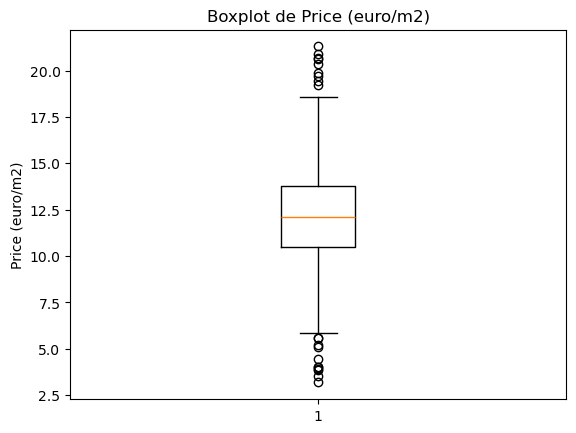

In [7]:
plt.boxplot(data['Price (euro/m2)'])
plt.title('Boxplot de Price (euro/m2)')
plt.ylabel('Price (euro/m2)')
plt.show()

Calidad del Dato
Presencia de outliers
Identificamos outliers utilizando el rango intercuartílico (IQR):

In [8]:
Q1 = data['Price (euro/m2)'].quantile(0.25)
Q3 = data['Price (euro/m2)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Corrección o imputación de outliers
Reemplazamos los outliers con la mediana para mantener la integridad de los datos:

In [9]:
median_value = data['Price (euro/m2)'].median()
data['Price (euro/m2)'] = data['Price (euro/m2)'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)


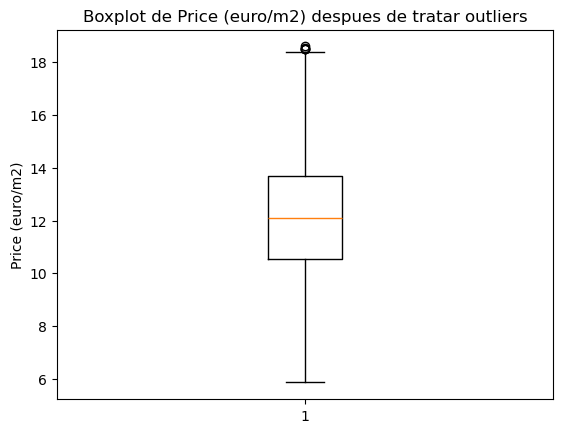

In [10]:
plt.boxplot(data['Price (euro/m2)'])
plt.title('Boxplot de Price (euro/m2) despues de tratar outliers')
plt.ylabel('Price (euro/m2)')
plt.show()

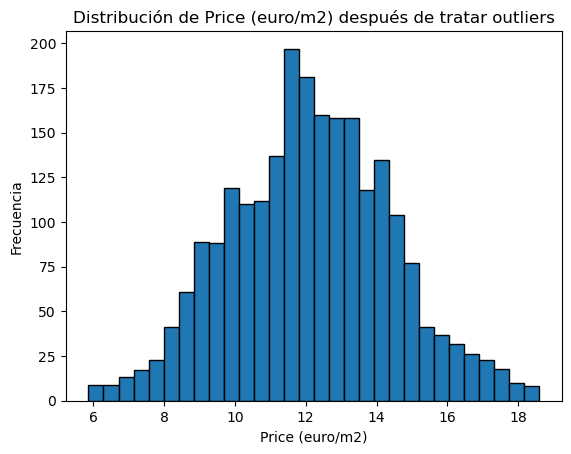

In [11]:
plt.hist(data['Price (euro/m2)'], bins=30, edgecolor='k')
plt.title('Distribución de Price (euro/m2) después de tratar outliers')
plt.xlabel('Price (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

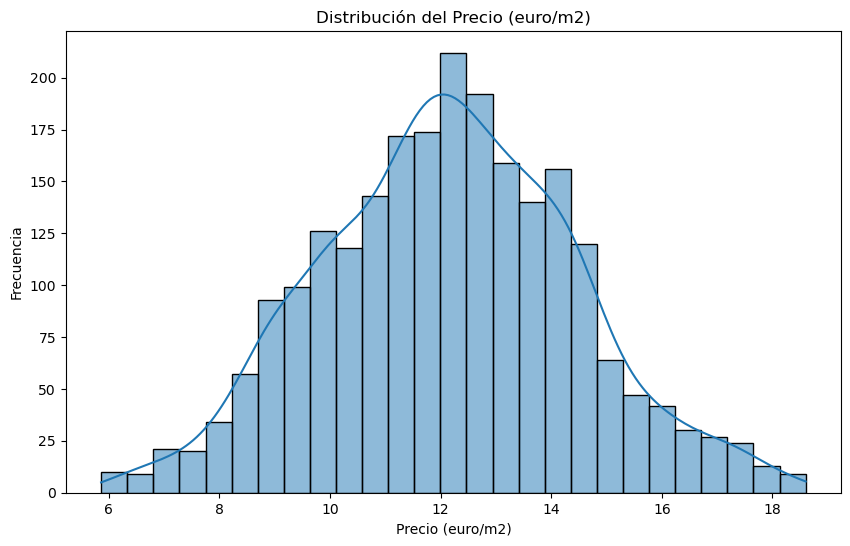

In [12]:
# Histograma y KDE
plt.figure(figsize=(10, 6))
sns.histplot(data['Price (euro/m2)'], kde=True)
plt.title('Distribución del Precio (euro/m2)')
plt.xlabel('Precio (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
stat, p = stats.shapiro(data['Price (euro/m2)'])
print('Prueba de Shapiro-Wilk')
print('Estadístico=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Distribución probablemente normal')
else:
    print('Distribución probablemente no normal')

# Prueba de Kolmogorov-Smirnov para 'Price (euro/m2)'
d, p_value = stats.kstest(data['Price (euro/m2)'], 'norm', args=(data['Price (euro/m2)'].mean(), data['Price (euro/m2)'].std()))
print('Prueba de Kolmogorov-Smirnov')
print('Estadístico=%.3f, p=%.3f' % (d, p_value))
if p_value > 0.05:
    print('Distribución probablemente normal')
else:
    print('Distribución probablemente no normal')

Prueba de Shapiro-Wilk
Estadístico=0.998, p=0.002
Distribución probablemente no normal
Prueba de Kolmogorov-Smirnov
Estadístico=0.016, p=0.619
Distribución probablemente normal


LA DISTRIBUCIION NO ES NORMAL, Y FALLA LA NORMALIZACION CON METODO BOX-COX Y CON METODO NORMALIZACION LOGARITMICA,
POR LO QUE SE SUGIERE LA ELECCION DE OTRO TIPO DE REGRESEION PARA ENTRENAMIENTO Y EVALUACION DE MODELO 

Selección de Variables Altamente Correladas
Calculamos la matriz de correlación para identificar variables altamente correlacionadas con la variable objetivo:

In [14]:
# Seleccionamos solo las columnas numéricas del DataFrame
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación solo para las columnas numéricas
correlation_matrix = numeric_data.corr()
highly_correlated_vars = correlation_matrix['Price (euro/m2)'].sort_values(ascending=False)

print(highly_correlated_vars)

Price (euro/m2)       1.000000
Price (euro/month)    0.784603
Year                  0.467137
Trimester             0.053613
Name: Price (euro/m2), dtype: float64


Binarización de Categóricas
Convertimos las variables categóricas en variables binarias utilizando One-Hot Encoding:

In [15]:
data_encoded = pd.get_dummies(data, columns=['District', 'Neighbourhood'])
data_encoded.head()

,Year,Trimester,Price (euro/month),Price (euro/m2),District_Ciutat Vella,District_Eixample,District_Gracia,District_Horta-Guinardo,District_Les Corts,District_Nou Barris,...,Neighbourhood_la Teixonera,Neighbourhood_la Trinitat Nova,Neighbourhood_la Trinitat Vella,Neighbourhood_la Vall d'Hebron,Neighbourhood_la Verneda i la Pau,Neighbourhood_la Vila Olimpica del Poblenou,Neighbourhood_la Vila de Gracia,Neighbourhood_les Corts,Neighbourhood_les Roquetes,Neighbourhood_les Tres Torres
0,2014,1,589.55,10.76,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2014,1,712.79,10.58,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2014,1,540.71,14.40,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2014,1,673.44,11.01,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2014,1,736.09,10.42,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


División Train Test
Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba:

In [16]:

X = data_encoded.drop('Price (euro/m2)', axis=1)
y = data_encoded['Price (euro/m2)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Transformación (Escalado)
Escalamos los datos utilizando MinMaxScaler para que todas las características tengan el mismo rango:

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Modelo:
Entrenamos un modelo de regresión RIDGE con los datos escalados:

In [18]:

# Definir el modelo de regresión Ridge
ridge_model = Ridge()
# Entrenar y evaluar el modelo Ridge
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

Evaluación del Modelo
Evaluamos el rendimiento del modelo utilizando MAE, MSE y R²:

In [19]:

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'MAE (Ridge): {mae_ridge}, MSE (Ridge): {mse_ridge}, RMSE (Ridge): {rmse_ridge}, R² (Ridge): {r2_ridge}')

MAE (Ridge): 0.607612448267257, MSE (Ridge): 0.7824533789149293, RMSE (Ridge): 0.8845639484598777, R² (Ridge): 0.847514968129041


El modelo tiene un buen desempeño, con un alto valor de R² indicando que explica el 84.75% de la variabilidad de los datos.

6. Validación Cruzada Estratificada

In [20]:
from sklearn.model_selection import KFold, cross_val_score

# Validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)

print(f'Validación cruzada R² (Ridge): {scores_ridge.mean()}, {scores_ridge.std()}')


Validación cruzada R² (Ridge): 0.8560940748870116, 0.01813650583547809


SE HA COMPROBADO LA VALIDACION DEL MODELO CON UN UN R2 DE 0.856 

## Conclusiones : 

1. El modelo presenta un despues de la eleccion de modelos mas robustos a distribuciones probablemente no normales un desempeño R2 = 84.5% (menor que el modelo clusters kmeans)
2. A pesar de los ajustes, las predicciones son alejadas de la realidad, por lo que se decide continuar con modelos con otro tipo de gestion de outliers 